# Principal component analysis

Author: Pierre Ablin

In this lab, we will look at our first datasets, manipulate them, and implement principal component analysis.

We will rely on the amazing scikit-learn library.
First let's import some packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_digits

# 1) Manipulating datasets

We are first going to play with the *iris* dataset. This dataset contains the petal width, lenght and sepal width lenght of some iris flowers. It comes with scikit learn, we can simply load it by doing:

In [2]:
X, labels = load_iris(return_X_y=True)

Now, we have access to the dataset matrix, $X$ of size $n\times p$ where $n$ is the number of samples and $p$ the number of features.

In [3]:
print(X.shape)

(150, 4)


Here, X is of size `(150, 4)`, so we have $150$ samples and $4$ features.

**Exercise 1**: what is the second feature of the $51$st sample?

In [4]:
print(X[50, 1])

3.2


We can try to visualize the dataset, by plotting for instance the first feature in the $x$ axis and the second feature in the $y$ axis.

**Exercise 2**: Display the dataset in the way described above. What do you see?

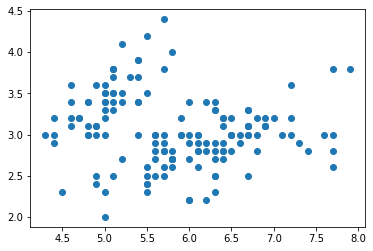

In [5]:
plt.scatter(X[:, 0], X[:, 1])

We also have loaded the target *labels* as the numpy array `labels`. There is one label per sample, which corresponds to the species of the flower.

**Exercise 3**: Display the first two features of the dataset and color each point with a color corresponding to its label. What do you see?

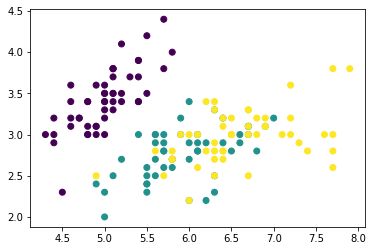

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=labels)

Here, you can see that the different classes are already quite well separated.

We are now going to take the digits dataset, that contains images:

In [7]:
X, labels = load_digits(return_X_y=True)

In [8]:
print(X.shape)

(1797, 64)


We see that $X$ contains $1797$ samples. Each sample has $64$ features, which correspond to the pixels of an $8 \times 8$ image. We can visualize each image by reshaping the vector into an $8\times 8$ array as follows:

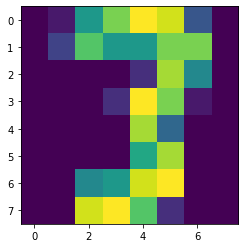

In [9]:
sample_idx = 23
img = X[sample_idx].reshape(8, 8)
plt.imshow(img)

**Exercise 4**: Do the same thing as in Exercise 3, but with the features number $24$ and $47$. What do you see?

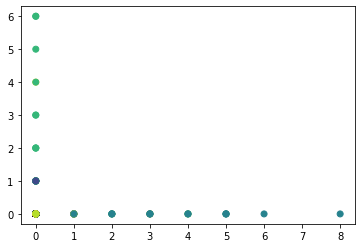

In [10]:
plt.scatter(X[:, 23], X[:, 47], c=labels)

This is clearly a poor way to visualize the dataset ! In order to get a better idea of what is going on, we will now perform a PCA.

# 2) Principal component analysis

The first step for a PCA is to shift the dataset so that its mean is $0$.

**Exercise 5** Create `X_centered` which contains the centered dataset. To do so, you should subtract the average value of the features to $X$.

In [11]:
average = np.mean(X, axis=0)
X_centered = X - average

You are now ready to code the PCA of X. We will first code the *deflation approach*.

**Exercise 6** Write a function `get_principal_component(X)` that returns the first principal component of the dataset $X$ and the corresponding basis vector.

In [12]:
def get_principal_component(X):
    '''
    Input
    -----
    X : centered dataset of size n x p
    
    Output
    ------
    w : vector of size p, the direction of maximal variance in X.
        Must be of norm 1.
    y : vector of size n, the representation of each sample.
    
    We should have X ~= y w^T
    '''
    n, p = X.shape
    # Form covariance
    C = np.dot(X.T, X) / n
    # Get leading eigenvector
    eigvals, eigvecs = np.linalg.eigh(C)  # use eigh since C is symmetric
    w = eigvecs[:, -1]  # eigenvector corresponding to the largest eigenvalue
    y = np.dot(X, w)  # use the projection formula
    
    return w, y


w, y = get_principal_component(X_centered)
print('Squared norm of X : %.2e' % np.mean(X_centered ** 2))
residual = X_centered - np.outer(y, w)
print('Squared norm of X - yw^T : %.2e' % np.mean(residual ** 2))  # must be smaller than the norm of X

Squared norm of X : 1.88e+01
Squared norm of X - yw^T : 1.60e+01


**Exercise 7**: display the basis vector w as an image. You should get the same thing as in the slides :)

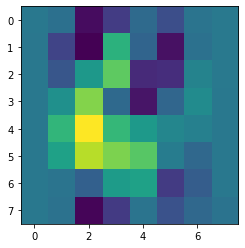

In [13]:
plt.imshow(w.reshape(8, 8))

**Exercise 8** Now, write a function to compute the PCA with dimension $k$, using the function `get_principal_component(X)` iteratively. Display the first 10 basis vectors

In [14]:
def deflation_pca(X, k):
    '''
    Input
    -----
    X : centered dataset of size n x p
    
    k : target dimension
    
    Output
    ------
    W : array of size k x p, w[i] corresponds to the i-th basis vector
    
    Y : array of size n x k, Y[j] corresponds to the representation of
        the sample j in the basis W.
    
    We should have X ~= WY
    '''
    n, p = X.shape
    # Initialize vectors
    W = np.zeros((k, p))
    Y = np.zeros((n, k)) 
    # Deflation
    X_deflated = X.copy()  # copy to avoid changing the initial dataset
    for i in range(k):
        w, y = get_principal_component(X_deflated)
        W[i] = w
        Y[:, i] = y
        X_deflated = X_deflated - np.outer(y, w)        
    return W, Y


W, Y = deflation_pca(X_centered, 3)

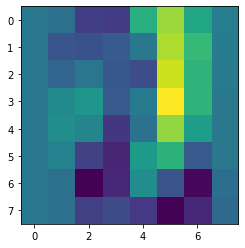

In [15]:
idx = 2

plt.imshow(W[idx].reshape(8, 8))

**Exercise 9**: Now, code a method that does the computation in parralel, using a single eigenvalue decomposition of the covariance. The two methods must output the same result.

In [16]:
def parallel_pca(X, k):
    '''
    Input
    -----
    X : centered dataset of size n x p
    
    k : target dimension
    
    Output
    ------
    W : array of size k x p, w[i] corresponds to the i-th basis vector
    
    Y : array of size n x k, Y[j] corresponds to the representation of
        the sample j in the basis W.
    
    We should have X ~= WY
    '''
    n, p = X.shape
    # Form covariance
    C = np.dot(X.T, X) / n
    # Get leading eigenvector
    eigvals, eigvecs = np.linalg.eigh(C)  # use eigh since C is symmetric
    W = eigvecs[:, -k:].T  # eigenvector corresponding to the largest eigenvalue
    Y = np.dot(X, W.T)  # use the projection formula
    
    return W, Y

W, Y = parallel_pca(X_centered, 3)

**Exercise 10**: Plot the evolution of the reconstruction error as a function of $k$.

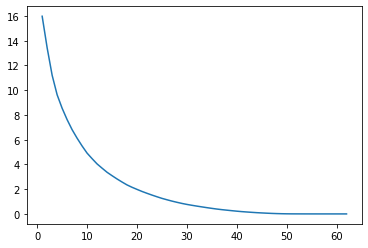

In [17]:
error_list = []

for k in np.arange(1, 63):
    W, Y = parallel_pca(X_centered, k)
    residual = X_centered - np.dot(Y, W)
    error = np.mean(residual ** 2)
    error_list.append(error)

plt.plot(np.arange(1, 63), error_list)

**Exercise 11**: plot the reconstruction of an image for different values of $k$

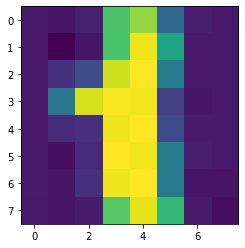

In [18]:
idx = 1

k = 40
W, Y = parallel_pca(X_centered, k)
x_reconstructed = Y[idx].dot(W) + average 
plt.imshow(x_reconstructed.reshape(8, 8))

**Exercise 12** Visualize the dataset in 2D using PCA

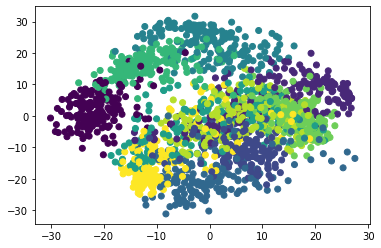

In [19]:
W, Y = parallel_pca(X_centered, 2)

plt.scatter(Y[:, 0], Y[:, 1], c=labels)

This is much better than just vizualizing two features ! 